In [0]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.vision.models import *
from fastai.vision.models.unet import *
import matplotlib.pyplot as plt
from fastai.metrics import psnr
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import random
from skimage import io
import re
from fastai.callbacks import Hooks
from fastai.callbacks.hooks import *
import cv2

In [0]:
path = untar_data(URLs.IMAGENETTE_160)

train_files = os.listdir(path/'train/n01440764')
train_files = list(train_files)

valid_files = os.listdir(path/'val/n01440764')
valid_files = list(valid_files)

In [0]:
class CustomDataset(Dataset):
    def __init__(self,root, files,img_size=240, tfms=None):
        self.root = root
        self.files = files
        self.img_size = img_size
        self.tfms = tfms
        
    def __len__(self): return len(self.files)
        
    def show(self,idx):
        sample = self.__getitem__(idx)
        #fig=plt.figure(figsize=(5, 5))
        f, ax = plt.subplots(1,2)
        #import pdb;pdb.set_trace()
        #stds = np.array([0.229, 0.224, 0.225])
        #means = np.array([0.485, 0.456, 0.406])
        x = (sample[0][0].numpy())*255
        y = (sample[1][0].numpy())*255
        #import pdb;pdb.set_trace()
        ax[0].imshow(x.astype(np.uint8),cmap="gray")
        ax[1].imshow(y.astype(np.uint8),cmap="gray")    
        
            
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = cv2.imread(self.root + '/' + self.files[idx])
        luma = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)[:,:,0]
        #zeros = np.zeros((3,luma.shape[0],luma.shape[1]),dtype="float32")
        luma = np.expand_dims(luma,axis=0).astype("float32")/255

        #try:
        #    img = io.imread(self.root + '/' + self.files[idx]).astype("float32").transpose(2,0,1)/255
        #except:
        #    img = io.imread(self.root + '/' + self.files[idx]).astype("float32")
        #    zeros = np.zeros((3,img.shape[0],img.shape[1]),dtype="float32")
        #    img = (np.expand_dims(img,axis=0) + zeros)/255

        
        if self.tfms: 
            #norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            luma = fastai.vision.Image(torch.from_numpy(luma))
            luma = luma.apply_tfms(self.tfms, size=self.img_size)
            #img = norm(img.data)
            #img = self.tfms(Image.fromarray(img))
            x = torch.zeros((3,240,240),dtype=torch.float32) + luma.data
        return x, luma.data

In [0]:
#tfms = transforms.Compose([
#        transforms.RandomResizedCrop(160,scale=(0.8,1)),
#        transforms.RandomHorizontalFlip(),
#        transforms.ToTensor(),
#        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

tfms = get_transforms(flip_vert=True,max_rotate=45,max_lighting=None)

In [0]:
train_ds = CustomDataset(str(path)+'/train/n01440764',train_files,tfms=tfms[0])
valid_ds = CustomDataset(str(path)+'/val/n01440764',valid_files,tfms=tfms[1])

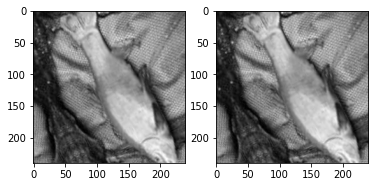

In [6]:
train_ds.show(0)

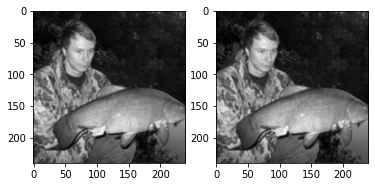

In [7]:
valid_ds.show(0)

In [0]:
train_dl = DataLoader(train_ds, batch_size=4,shuffle=True,num_workers=2)
valid_dl = DataLoader(valid_ds, batch_size=4,shuffle=True,num_workers=2)

In [0]:
data = DataBunch(train_dl,valid_dl)

# Defining a fully convolutional Autoencoder

In [0]:
encoder = models.resnet18(pretrained=True)
encoder = nn.Sequential(*list(encoder.children())[:-1])

In [0]:
def _get_sfs_idxs(sizes:Sizes) -> List[int]:
    "Get the indexes of the layers where the size of the activation changes."
    feature_szs = [size[-1] for size in sizes]
    sfs_idxs = list(np.where(np.array(feature_szs[:-1]) != np.array(feature_szs[1:]))[0])
    if feature_szs[0] != feature_szs[1]: sfs_idxs = [0] + sfs_idxs
    return sfs_idxs

#unet block without skip connections
class UnetBlock(Module):
    "A quasi-UNet block, using `PixelShuffle_ICNR upsampling`."
    def __init__(self, up_in_c:int, x_in_c:int, hook:Hook, final_div:bool=True, blur:bool=False, leaky:float=None,
                 self_attention:bool=False, **kwargs):
        self.hook = hook
        self.up_in_c= up_in_c
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, leaky=leaky, **kwargs)
        self.bn = batchnorm_2d(x_in_c)
        ni = (up_in_c//2)# + x_in_c)//3
        #import pdb;pdb.set_trace()
        nf = ni if final_div else ni//2
        self.conv1 = conv_layer(ni, nf, leaky=leaky, **kwargs)
        self.conv2 = conv_layer(nf, nf, leaky=leaky, self_attention=self_attention, **kwargs)
        self.relu = relu(leaky=leaky)

    def forward(self, up_in:Tensor) -> Tensor:
        s = self.hook.stored
        up_out = self.shuf(up_in)
        ssh = s.shape[-2:]
        if ssh != up_out.shape[-2:]:
            up_out = F.interpolate(up_out, s.shape[-2:], mode='nearest')
        cat_x = self.relu(up_out)
        #import pdb;pdb.set_trace()
        return self.conv2(self.conv1(cat_x))


class DynamicUnet(SequentialEx):
    "Create a U-Net from a given architecture."
    def __init__(self, encoder:nn.Module, n_classes:int, img_size:Tuple[int,int]=(256,256), blur:bool=False, blur_final=True, self_attention:bool=False,
                 y_range:Optional[Tuple[float,float]]=None,
                 last_cross:bool=True, bottle:bool=False, **kwargs):
        imsize = img_size
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs)))
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs], detach=False)
        x = dummy_eval(encoder, imsize).detach()

        ni = sfs_szs[-1][1]
        middle_conv = nn.Sequential(conv_layer(ni, ni*2, **kwargs),
                                    conv_layer(ni*2, ni, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, batchnorm_2d(ni), nn.ReLU(), middle_conv]

        for i,idx in enumerate(sfs_idxs):
            not_final = i!=len(sfs_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sfs_szs[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sfs_idxs)-3)
            unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=do_blur, self_attention=sa,
                                   **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sfs_szs[0][-2:]: layers.append(PixelShuffle_ICNR(ni, **kwargs))
        x = PixelShuffle_ICNR(ni)(x)
        if imsize != x.shape[-2:]: layers.append(Lambda(lambda x: F.interpolate(x, imsize, mode='nearest')))
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(res_block(ni, bottle=bottle, **kwargs))
        layers += [conv_layer(ni, n_classes, ks=1, use_activ=False, **kwargs)]
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

In [0]:
autoencoder = DynamicUnet(encoder, n_classes=1, img_size=(240,240), blur=False, blur_final=True,
              self_attention=False, y_range=None, norm_type=None, last_cross=False,
              bottle=True)

In [0]:
learn = Learner(data, autoencoder, loss_func=nn.MSELoss(),callback_fns=ShowGraph, metrics=mean_absolute_error)

#splitting the model into the encoder and the decoder
learn.split([learn.model[0],
             learn.model[1:]])

apply_init(learn.model[1:], nn.init.kaiming_normal_)

learn.freeze_to(1)

epoch,train_loss,valid_loss,mean_absolute_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


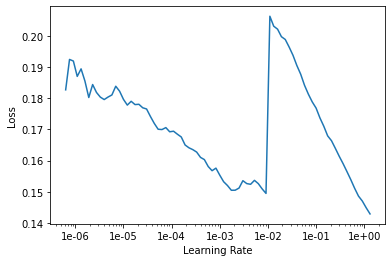

In [152]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.087502,0.090502,0.240920,00:15
1,0.077847,0.082611,0.229537,00:15
2,0.072470,0.081858,0.226512,00:15
3,0.068606,0.076599,0.227962,00:15
4,0.056901,0.057962,0.199625,00:15
5,0.055305,0.057318,0.198721,00:15
6,0.051943,0.052258,0.188902,00:15
7,0.052380,0.050223,0.184484,00:15
8,0.049622,0.050109,0.185429,00:15
9,0.050072,0.047517,0.176105,00:15


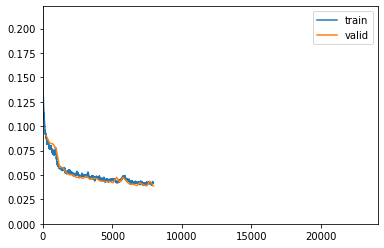

KeyboardInterrupt: ignored

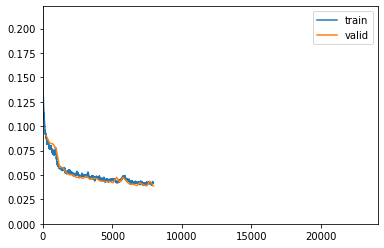

In [153]:
learn.fit_one_cycle(100,max_lr=1e-3)

In [0]:
def show_results(learn,figsize=(10,10)):

    inputs,classes = next(iter(learn.data.valid_dl))
    learn.model.train()
    preds = learn.model(inputs)
    #stds = np.array([0.229, 0.224, 0.225])
    #means = np.array([0.485, 0.456, 0.406])
    #inp = (inputs[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255
    #import pdb;pdb.set_trace()
    target = (classes[0][0].cpu().detach().numpy())*255
    pred = (preds[0][0].cpu().detach().numpy())*255

    mse = np.sum(((pred - target)**2))/(pred.shape[0]*pred.shape[1])
    psnr = 10*np.log10(255/mse)

    print('MSE:',mse)
    print('PSNR:', psnr)


    fig = plt.figure(figsize=figsize)
    #ax0 = fig.add_subplot(131)
    #ax0.imshow(inp.astype(np.uint8))
    #ax0.title.set_text('Input')
    ax1 = fig.add_subplot(132)
    ax1.imshow(target.astype(np.uint8),cmap="gray")
    ax1.title.set_text('Target')
    ax2 = fig.add_subplot(133)
    ax2.imshow(pred.astype(np.uint8),cmap="gray")
    ax2.title.set_text('Prediction')

MSE: 2822.9683333333332
PSNR: -10.441658260389548


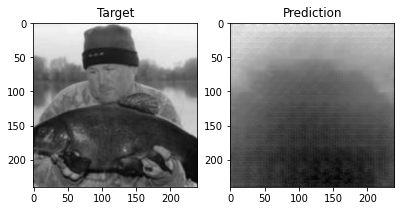

In [168]:
show_results(learn)

# Defining a linear decoder

In [0]:
data = DataBunch(train_dl,valid_dl)

In [0]:
encoder = models.resnet18(pretrained=True)
encoder = nn.Sequential(*list(encoder.children())[:-1])

In [0]:
#decoder = nn.Sequential(Flatten(),nn.Linear(512,5120),nn.ReLU(),nn.Linear(5120,57600),Lambda(lambda x: x.view(4,1,240,240)))

In [0]:
 class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.flat = Flatten()
        self.lin1 = nn.Linear(512,5120)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(5120,57600)
    def forward(self,x):
        bs = x.shape[0]
        x = self.flat(x)
        x = self.lin1(x)
        x = self.relu(x)
        x = self.lin2(x)
        return x.view(bs,1,240,240)

In [0]:
autoencoder = nn.Sequential(encoder,Decoder())

In [0]:
for xb,yb in valid_dl:
    try:
        out = autoencoder(xb)
    except:
        import pdb;pdb.set_trace()

In [0]:
learn = Learner(data, autoencoder, loss_func=nn.MSELoss(),callback_fns=ShowGraph, metrics=mean_absolute_error)

#splitting the model into the encoder and the decoder
learn.split([learn.model[0],
             learn.model[1]])

apply_init(learn.model[1], nn.init.kaiming_normal_)

learn.freeze_to(1)

epoch,train_loss,valid_loss,mean_absolute_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


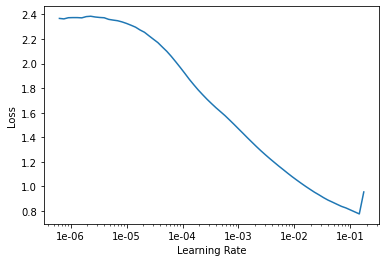

In [33]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.064823,0.072695,0.208070,01:05
1,0.056700,0.059308,0.193881,01:05
2,0.056656,0.059057,0.192437,01:05
3,0.054302,0.059636,0.199840,01:05
4,0.054465,0.062996,0.207902,01:05
5,0.052188,0.050395,0.182146,01:05
6,0.050302,0.048110,0.180888,01:05
7,0.047045,0.045026,0.169683,01:05
8,0.042318,0.040016,0.159575,01:05
9,0.040546,0.039667,0.158980,01:05


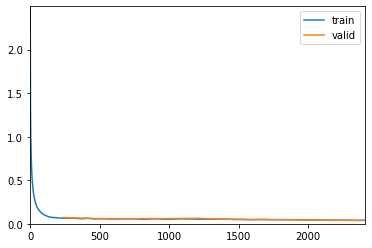

In [34]:
learn.fit_one_cycle(10,max_lr=1e-2)

MSE: 2569.505833333333
PSNR: -10.033094275306505


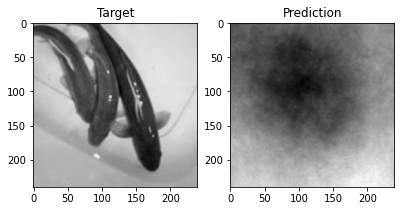

In [38]:
show_results(learn)